# Classification with Kernel Density Matrices

This notebook illustrates how to use [Kernel Density Matrices](https://github.com/fagonzalezo/kdm) for classification.

In [ ]:
# Uncomment to install the required packages
# !pip install git+https://github.com/fagonzalezo/kdm.git

In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras import optimizers
from keras import losses
from keras import metrics

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import kdm


In [2]:
# Function to visualize a 2D dataset
def plot_data(X, y):
    y_unique = np.unique(y)
    colors = plt.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        plt.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    plt.legend(loc="best")
    plt.title("Data")

# Function to visualize the decission surface of a classifier
def plot_decision_region(X, pred_fun):
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 50)
    y_vals = np.linspace(min_y, max_y, 50)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    vals = [[XX[i, j], YY[i, j]] for i in range(grid_r) for j in range(grid_c)]
    preds = pred_fun(np.array(vals))
    ZZ = np.reshape(preds, (grid_r, grid_c))
    print(np.min(preds), np.min(ZZ))
    plt.contourf(XX, YY, ZZ, 100, cmap = plt.cm.coolwarm, vmin= 0, vmax=1)
    plt.colorbar()
    CS = plt.contour(XX, YY, ZZ, 100, levels = [0.1*i for i in range(1,10)])
    plt.clabel(CS, inline=1, fontsize=10)
    plt.xlabel("x")
    plt.ylabel("y")

def gen_pred_fun(clf):
    def pred_fun(X):
        return clf.predict(X)[:, 1]
    return pred_fun



## 1. Shallow model with toy dataset

We will use a toy dataset to illustrate the use of Kernel Density Matrices for classification. 

/var/folders/p_/nhqsddwd6w3923l9m2_nxxzm0000gp/T/ipykernel_4033/4088681512.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(this_X[:, 0], this_X[:, 1],  c=color,


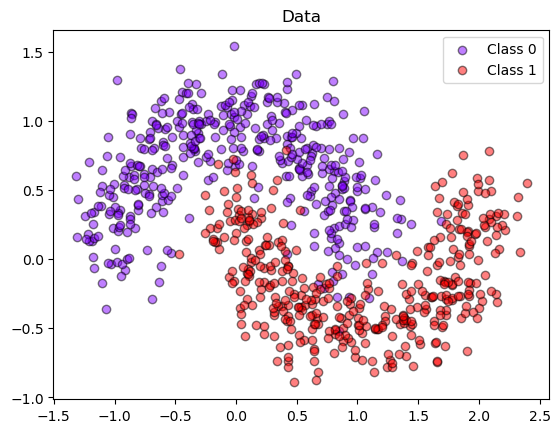

In [3]:
# Create a 2 moons dataset
X, y = make_moons(n_samples=1000, noise=0.2, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

plot_data(X_train, y_train)

We use the KDMClassModel to train a shallow model that directly apply a KDM inference layer to the raw data. 

In [4]:
from kdm.models import KDMClassModel

encoded_size = 2
dim_y = 2
encoder = keras.layers.Identity()
n_comp = 10

kdm_model = KDMClassModel(encoded_size=encoded_size,
                            dim_y=dim_y,
                            encoder=encoder,
                            n_comp=n_comp,
                            sigma=0.1)

# train the classifier
kdm_model.compile(optimizer=optimizers.Adam(learning_rate=5e-3),
                    loss=losses.sparse_categorical_crossentropy,
                    metrics=[metrics.sparse_categorical_accuracy])
kdm_model.predict(X_train[:10])
idx = np.random.randint(X_train.shape[0], size=n_comp)
kdm_model.init_components(X_train[idx], 
                          np.eye(2)[y_train[idx]],
                          init_sigma=True)

kdm_model.fit(X_train, y_train, epochs=25, batch_size=32, verbose=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Epoch 1/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3899 - sparse_categorical_accuracy: 0.8469
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2847 - sparse_categorical_accuracy: 0.8651
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2368 - sparse_categorical_accuracy: 0.8979
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1847 - sparse_categorical_accuracy: 0.9264
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1620 - sparse_categorical_accuracy: 0.9403
Epoch 6/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1606 - sparse_categorical_accuracy: 0.9452
Epoch 7/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0984 - sparse_categorical_accuracy: 0.9708
Epoch 8/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0879 - sparse_categorical_accuracy: 0.9671
Epoch 9/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1003 - sparse_categorical_accuracy: 0.9629
Epoch 10/25
25/25 ━━━━━━━━━━━━━━━━━

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2.960208e-06 2.960208e-06
Test loss: 0.08587365597486496
Test accuracy: 0.9599999785423279
Train loss: 0.08392488211393356
Train accuracy: 0.9662500023841858
Sigma: 0.3575478196144104


/var/folders/p_/nhqsddwd6w3923l9m2_nxxzm0000gp/T/ipykernel_4033/4088681512.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(this_X[:, 0], this_X[:, 1],  c=color,


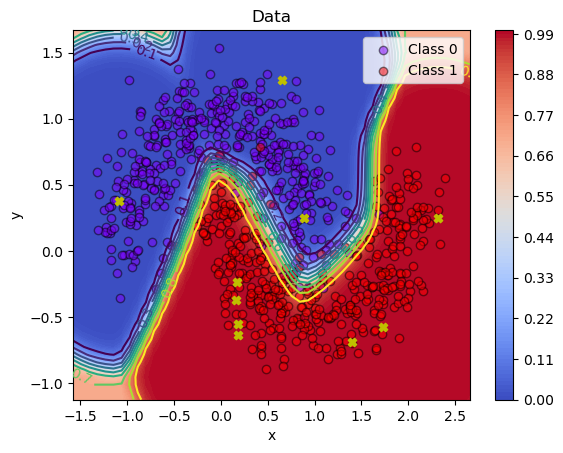

In [5]:
plot_decision_region(X, gen_pred_fun(kdm_model))
plot_data(X_train, y_train)
# plot the prototypes
plt.scatter(kdm_model.kdm.c_x.numpy()[:, 0], kdm_model.kdm.c_x.numpy()[:, 1], c='y', marker='X')
# Evaluate the classifier
score = kdm_model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
score = kdm_model.evaluate(X_train, y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])
print(f'Sigma: {kdm_model.kernel.sigma.numpy()}')


The model learn a joint KDM that can be seen as a set of prototypes, which are pairs of x and y values. The prototypes are shown in the plot above as yellow crosses. The model also learn a set of weights that are used to combine the prototypes to make predictions.

## 2. Deep KDM classifier model 

An example using the MNIST dataset. 

In [6]:
# Create a dataset from mnist using tf
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.


# reshape the data to include a channel dimension
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

# Partition the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.8, random_state=42)

def display_imgs(x, y=None):
    if not isinstance(x, (np.ndarray, np.generic)):
      x = np.array(x)
    plt.ioff()
    n = x.shape[0]
    fig, axs = plt.subplots(1, n, figsize=(n, 1))
    if y is not None:
      fig.suptitle(np.argmax(y, axis=1))
    for i in range(n):
      axs.flat[i].imshow(x[i].squeeze(), interpolation='none', cmap='gray')
      axs.flat[i].axis('off')
    plt.show()
    plt.close()
    plt.ion()


We define a deep encoder that will be used to map input images to a low-dimensional latent space.

In [8]:
kl = keras.layers

def create_encoder(input_shape, base_depth, encoded_size):
    encoder = keras.Sequential([
        kl.InputLayer(shape=input_shape),
        kl.Lambda(lambda x: x - 0.5),
        kl.Conv2D(base_depth, 5, strides=1,
                    padding='same', activation=keras.ops.leaky_relu),
        kl.Conv2D(base_depth, 5, strides=2,
                    padding='same', activation=keras.ops.leaky_relu),
        kl.Conv2D(2 * base_depth, 5, strides=1,
                    padding='same', activation=keras.ops.leaky_relu),
        kl.Conv2D(2 * base_depth, 5, strides=2,
                    padding='same', activation=keras.ops.leaky_relu),
        kl.Conv2D(4 * encoded_size, 7, strides=1,
                    padding='valid', activation=keras.ops.leaky_relu),
        kl.Dense(encoded_size,
                activation=None),#, activity_regularizer=tf.keras.regularizers.l2(1e-3)),
        #kl.layers.LayerNormalization(),
        kl.Flatten(),
    ])
    return encoder

The classifier model (KDMClassModel) receives as input a deep encoder, and applies it before applying the KDM inference layer.

In [9]:
input_shape = (28, 28, 1)
dim_y = 10 # number of classes

def run_experiment(base_depth=32, 
                   encoded_size=2, 
                   n_comp=64, 
                   sigma_mult=0.2, 
                   epochs=10,
                   batch_size=128):
    
    encoder = create_encoder(input_shape, base_depth, encoded_size)

    # warm up the encoder
    encoder_wmp = keras.Sequential([encoder, 
                                    keras.layers.Dense(10, activation='softmax')])
    encoder_wmp.predict(X_train[:10])
    encoder_wmp.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
                    loss=losses.sparse_categorical_crossentropy,
                    metrics=[metrics.sparse_categorical_accuracy])

    # train the encoder for 1 epoch
    encoder_wmp.fit(X_train, y_train, epochs=1, batch_size=64, verbose=1)

    # Create a KDM classifier model

    kdm_mnist = KDMClassModel(encoded_size=encoded_size,
                                dim_y=dim_y,
                                encoder=encoder,
                                n_comp=n_comp,
                                sigma=1.0,
                                w_train=True)

    # initialize the prototypes using random samples from the training set
    idx = np.random.randint(X_train.shape[0], size=n_comp)
    kdm_mnist.init_components(X_train[idx], keras.ops.one_hot(y_train[idx], 10), 
                            init_sigma=True, sigma_mult=sigma_mult)

    # Compile the model
    kdm_mnist.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
                        loss=losses.sparse_categorical_crossentropy,
                        metrics=[metrics.sparse_categorical_accuracy])

    # Callback to save the best model
    checkpoint = keras.callbacks.ModelCheckpoint('best_model.weights.h5', 
                                                 save_best_only=True,
                                                 save_weights_only=True)

    # train the classifier
    kdm_mnist.predict(X_train[:10])
    history = kdm_mnist.fit(X_train, y_train, 
                  validation_data=(X_val, y_val), 
                  epochs=epochs, 
                  batch_size=batch_size, 
                  callbacks=[checkpoint],
                  verbose=1) 

    kdm_mnist.load_weights('best_model.weights.h5')
    
    # Evaluate the classifier
    score = kdm_mnist.evaluate(X_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    score = kdm_mnist.evaluate(X_train, y_train, verbose=0)
    print('Train loss:', score[0])
    print('Train accuracy:', score[1])
    print(f'Sigma: {kdm_mnist.kernel.sigma.numpy()}')

    return kdm_mnist, history

kdm_mnist, history = run_experiment(epochs=10)

                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 91s 481ms/step - loss: 1.6071 - sparse_categorical_accuracy: 0.3528
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - loss: 0.5361 - sparse_categorical_accuracy: 0.8659 - val_loss: 0.3517 - val_sparse_categorical_accuracy: 0.9160
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - loss: 0.3036 - sparse_categorical_accuracy: 0.9284 - val_loss: 0.3204 - val_sparse_categorical_accuracy: 0.9215
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - loss: 0.2429 - sparse_categorical_accuracy: 0.9408 - val_loss: 0.2727 - val_sparse_categorical_accuracy: 0.9403
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - loss: 0.2072 - sparse_categorical_accuracy: 0.9550 - val_loss: 0.2398 - val_sparse_categorical_accuracy: 0.9451
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - loss: 0.1988 - sparse_categorical_accuracy: 0.9553 - val_loss: 0.2414 - val_

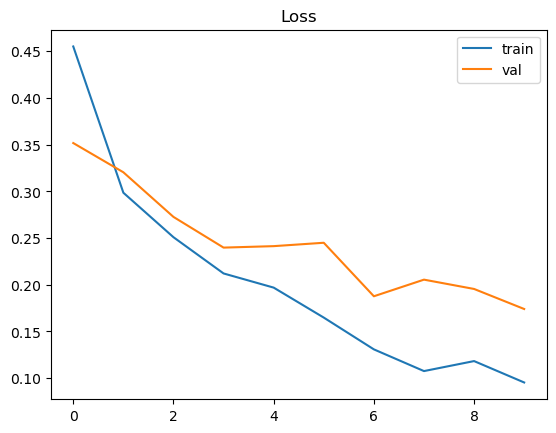

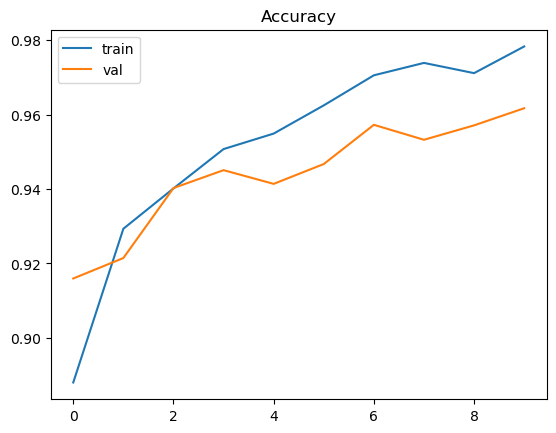

In [10]:
# Plot the training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.title('Loss')
plt.show()
plt.plot(history.history['sparse_categorical_accuracy'], label='train')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='val')
plt.legend()
plt.title('Accuracy')
plt.show()

We are using an embedding dimension (encoded_size) of 2 that allows us to visualize samples and prototypes in a 2D space. A higher value of encoded_size can be used for better classification performance.

313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step


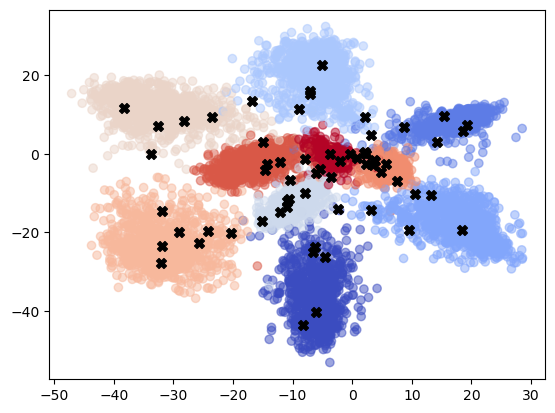

In [11]:
num_samples = 10000
encoder = kdm_mnist.encoder
encoded_samples = keras.ops.convert_to_numpy(encoder.predict(X_train[:num_samples]))
# Visualize the points in the feature space
plt.scatter(encoded_samples[:, 0], encoded_samples[:, 1], alpha=0.5, c=y_train[:num_samples], cmap=plt.cm.coolwarm)

prototypes = keras.ops.convert_to_numpy(kdm_mnist.kdm.c_x)
# plot the prototypes
plt.scatter(prototypes[:, 0], prototypes[:, 1], c='k', marker='X', s=50)
plt.show()

The figure above show training samples mapped to the latent space with different colors according to the class. The prototypes are shown as black crosses.

Next, we train a model with a larger embedding dimension.

Now we will visualize some prototypes of the model. 


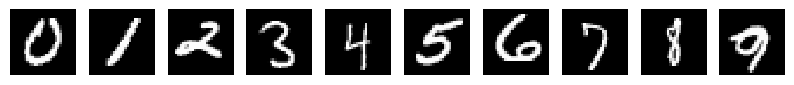

In [12]:
prototypes = np.zeros((10, 28, 28, 1))
for i in range(10):
    # find the prototypes for class i
    idx = keras.ops.convert_to_numpy(kdm_mnist.kdm.c_y).argmax(axis=1) == i
    # weights of the prototypes 
    weights = np.abs(keras.ops.convert_to_numpy(kdm_mnist.kdm.c_w))[idx]
    # find the index of the prototype with the highest weight
    max_idx = weights.argmax()
    # get the prototype
    emb_prot = keras.ops.convert_to_numpy(kdm_mnist.kdm.c_x)[idx][max_idx]
    # look for the closest embedded sample to the prototype
    dist = np.sum((encoded_samples - emb_prot)**2, axis=1)
    closest = np.argmin(dist)
    prototypes[i] = X_train[closest]

display_imgs(prototypes)



